In [1]:
import pandas as pd
%pylab inline
#%matplotlib nbagg

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pyhsmm
import pyhsmm.basic.distributions as distributions


In [3]:
path_to_file5sec = "/media/sf_VBox_Shared/London/accelerometer_5second/merged/__016563_2014-08-08 12-02-19.bin_day1.csv"
day1_5sec = pd.read_csv(path_to_file5sec)

In [4]:
day1_5sec = day1_5sec.set_index('timestamp')
day1_5sec.index = pd.to_datetime(day1_5sec.index)
print(min(day1_5sec.index))
print(max(day1_5sec.index))

2014-08-01 04:00:00
2014-08-02 03:59:55


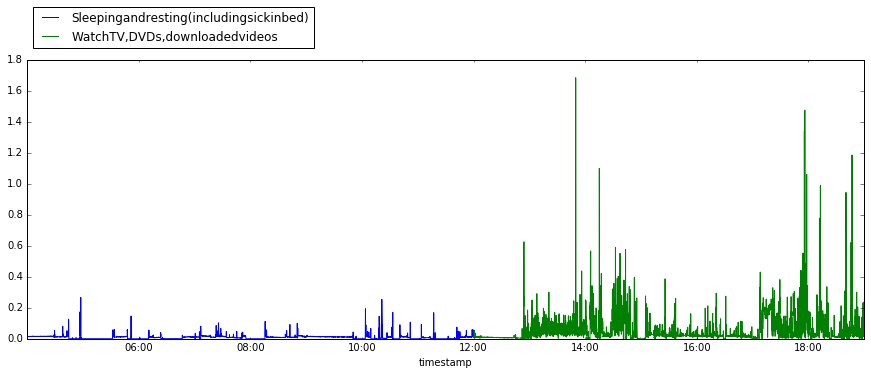

In [5]:
byAct = day1_5sec.groupby('Activity')
fig, ax = plt.subplots(figsize=(15,5))
for act,dfa in byAct:
    dfa['acceleration'].plot(label=act)
legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3);

In [6]:
X = np.column_stack([day1_5sec.acceleration, day1_5sec.anglex, day1_5sec.angley, day1_5sec.anglez])
column_names = day1_5sec.columns[0:4]
print(column_names)
print(X.shape)

Index([u'acceleration', u'anglex', u'angley', u'anglez'], dtype='object')
(17280, 4)


In [7]:
#Parameters for HSMM
Nmax = 5
affine = True
dim = X.shape[1]

In [30]:
#Observations are gaussians
obs_hypparams = {'mu_0': np.zeros(dim), #mean of gaussians
                'sigma_0': np.eye(dim), #std of gaussians
                 'kappa_0': 0.3, #What is this?
                 'nu_0': dim+5 #What is this?
                }

#duration is going to be poisson, so prior is a gamma distribution (params alpha betta)
expected_lam = 12*30
dur_hypparams = {'alpha_0': 2*expected_lam,
                'beta_0': 2}

In [31]:
obs_distns = [distributions.Gaussian(**obs_hypparams) for state in range(Nmax)]
dur_distns = [distributions.PoissonDuration(**dur_hypparams) for state in range(Nmax)]


In [32]:
model = pyhsmm.models.WeakLimitHDPHSMM(
        alpha=6.,gamma=6., # better to sample over these; see concentration-resampling.py
        init_state_concentration=6., 
        obs_distns=obs_distns,
        dur_distns=dur_distns)

In [33]:
model.add_data(X, trunc=600)

In [34]:
model.resample_model()

In [35]:
#resample
import copy
models = []
for idx in xrange(100):
    model.resample_model()
    if (idx+1) % 10 == 0:
        print(idx)
        models.append(copy.deepcopy(model))

9
19
29
39
49
59
69
79
89
99


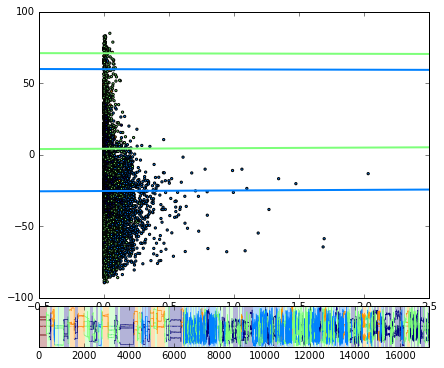

In [36]:
#model.stateseqs
plots = model.plot()
plt.savefig('model')

In [37]:
data = day1_5sec
hidden_states = model.stateseqs[0]

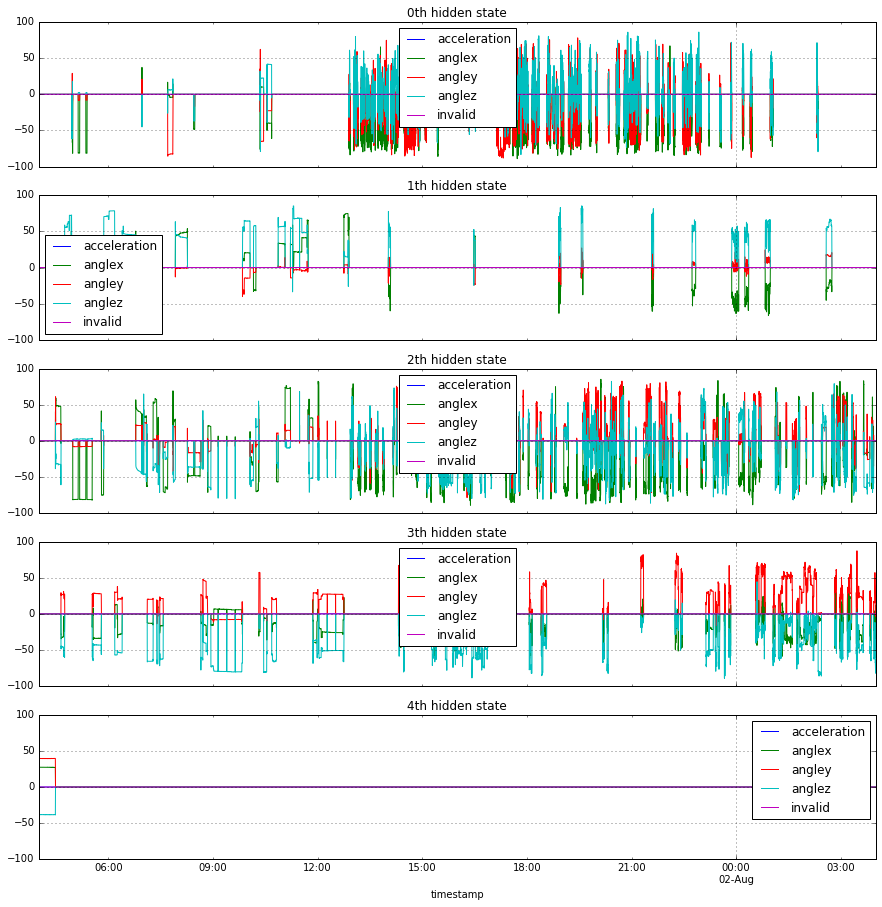

In [38]:
fig, axs = plt.subplots(model.num_states, sharex=True, sharey=True, figsize=(15,15))
colours = cm.rainbow(np.linspace(0, 1, model.num_states))
for i, (ax, colour) in enumerate(zip(axs, colours)):
    # Use fancy indexing to plot data in each state.
    data_to_plot = data.copy()
    data_to_plot[model.stateseqs[0] != i] = 0
    data_to_plot.plot(ax=ax)
    #ax.plot(plotdata, ".-")
    ax.set_title("{0}th hidden state".format(i))

    # Format the ticks.
    #ax.xaxis.set_major_locator(YearLocator())
    #ax.xaxis.set_minor_locator(MonthLocator())

    ax.grid(True)

plt.show()

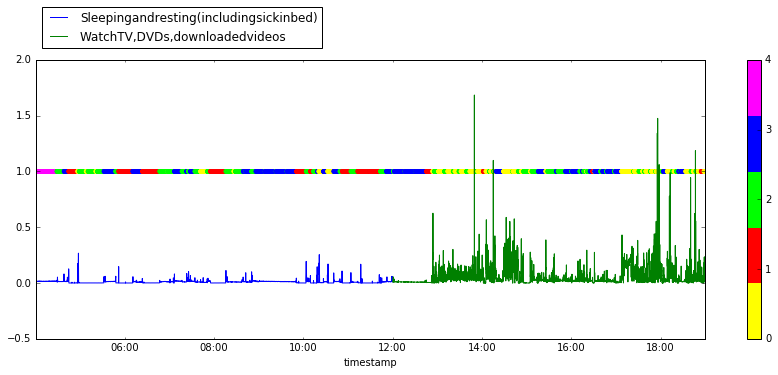

In [54]:
fig = figure(figsize=(15,5))
byAct = day1_5sec.groupby('Activity')
fig, ax = plt.subplots(figsize=(15,5))
for act,dfa in byAct:
    dfa['acceleration'].plot(label=act)
legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3);
colormap = {0: (1,1,0), 1: (1,0,0), 2: (0,1,0), 3: (0,0,1), 4:(1,0,1)}
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('name', colormap.values(), model.num_states)
state_colors = [colormap[i] for i in hidden_states]
sca = plt.scatter(day1_5sec.index, np.ones_like(hidden_states), c=hidden_states, cmap=cmap,  edgecolors='none')
#plt.xlim(min(), max(byAct.index))
plt.colorbar(sca, ticks=np.arange(np.min(hidden_states),np.max(hidden_states)+1))

In [40]:
model.trans_distn.full_trans_matrix

array([[  9.31090432e-01,   7.22441853e-03,   5.13286335e-02,
          1.03564932e-02,   2.25995749e-08],
       [  7.44940573e-02,   8.10151697e-01,   1.08731002e-01,
          6.53010109e-03,   9.31426813e-05],
       [  1.20455556e-02,   2.76673966e-03,   9.67011907e-01,
          1.81757978e-02,   6.04938636e-14],
       [  1.68650585e-02,   1.01453271e-02,   3.88825410e-02,
          9.34107073e-01,   5.44722889e-12],
       [  6.53544951e-02,   2.08606718e-01,   2.61367955e-01,
          1.96769794e-01,   2.67901038e-01]])

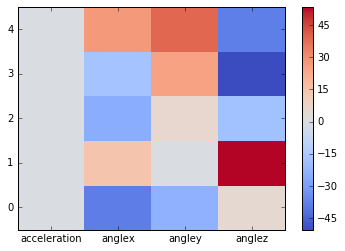

In [41]:
plotdata = np.array([d.mu for d in model.obs_distns])

fig, ax = plt.subplots()
colorplot = ax.pcolor(plotdata, cmap='coolwarm',)
ax.set_xticks(np.arange(plotdata.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(plotdata.shape[0])+0.5, minor=False)
ax.set_xticklabels(column_names, minor=False)
ax.set_yticklabels(range(plotdata.shape[0]), minor=False)
plt.colorbar(colorplot)

()


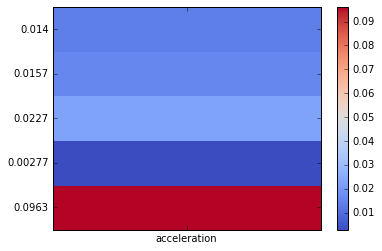

In [42]:
plotdata = plotdata[:,0][:,np.newaxis]
grouplabels = ["{:.3}".format(x) for x in plotdata[:,0]]
fig, ax = plt.subplots()
colorplot = ax.pcolor(plotdata, cmap='coolwarm',)
ax.set_xticks(np.arange(plotdata.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(plotdata.shape[0])+0.5, minor=False)
ax.set_xticklabels(column_names, minor=False)
ax.set_yticklabels(grouplabels, minor=False)
fig.colorbar(colorplot)
print()

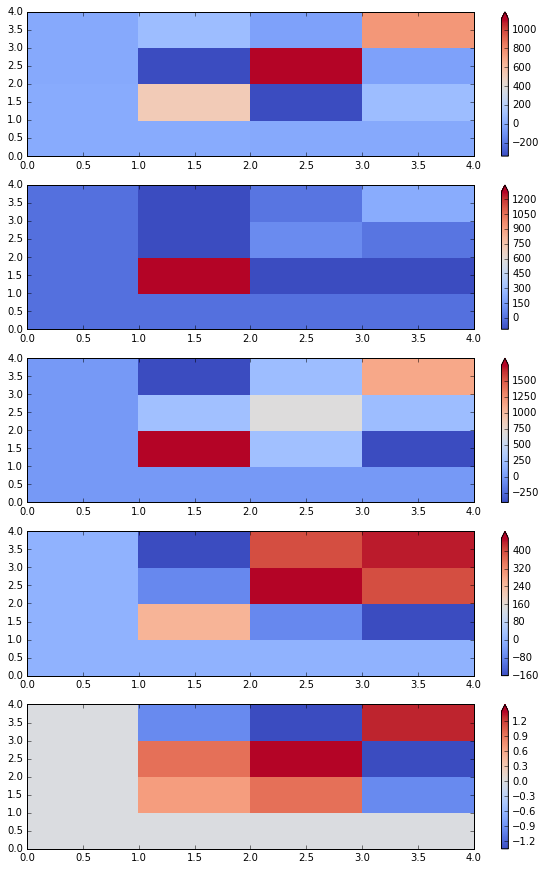

In [43]:
fig, axs = plt.subplots(nrows=model.num_states, ncols=1,  figsize = (10, 15))
for i in range(model.num_states):
    im = axs[i].pcolor(model.obs_distns[i].sigma, cmap='coolwarm',)
    fig.colorbar(im, ax = axs[i], extend='max')
#colorbar()
show()

NameError: name 'nr_states' is not defined

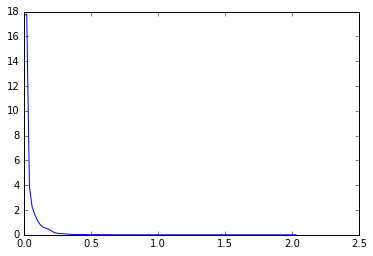

In [44]:
from scipy.stats.kde import gaussian_kde

variable = "acceleration"

fig, ax = subplots()
#day1_5sec.hist(variable, bins=100)
vals = day1_5sec[variable]
kde = gaussian_kde(vals)
d = np.linspace(min(vals), max(vals), 100)
p = plot(d, kde(d), label="all")

for i in range(nr_states):
    mask = hidden_states == i
    kde = gaussian_kde(vals[mask])
    plot(d, kde(d), label=str(i))
    #p = plt.hist(day1_5sec[mask][variable], bins=100)
ax.set_xlim(0,0.1)
legend()
show()

In [ ]:
column_names